<a href="https://colab.research.google.com/github/Mahedi-Shuvro/AutoLand-UGV-UAV-/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive

In [97]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Libraries

In [98]:
import os                                          # Interact with the file system
import typing                                      # Provides type hints for functions and variables.
import pandas as pd                                # Data manipulation and analysis with DataFrames such as Data loading, merging, indexing
import numpy as np                                 # Core scientific computing library for numerical operations and array manipulations
import joblib                                      # Efficient saving/loading of models and arrays.
import scipy.stats                                 # Feature extraction using statistical metrics
from sklearn.linear_model import LinearRegression  # For feature engineering (e.g., slope of trendline before/after break).Baseline modeling or as part of ensemble.
from lightgbm import LGBMClassifier                # Main classifier: High-performance gradient boosting classifier for predicting structural breaks
from sklearn.metrics import roc_auc_score          # For Model evaluation

### Data Load & Analysis

source: https://hub.crunchdao.com/competitions/structural-break/resources/datasets

Each time series is split into two periods:

* period=0: before the potential break


* period=1: after the boundary


provided with:
* X_train.parquet: A large dataframe with time series data and a MultiIndex (id, time) with columns value and period


* y_train.parquet: A binary label (True/False) for each time series, indicating presence of a structural break at the boundary


* X_test.reduced.parquet: Test set with 100 time series


* y_test.reduced.parquet: Ground truth for test set (for evaluation purposes)

Load all Parquet files

In [99]:
X_train = pd.read_parquet('/content/drive/MyDrive/ADIALab_StructuralBreakChallenge/X_train.parquet')
y_train = pd.read_parquet('/content/drive/MyDrive/ADIALab_StructuralBreakChallenge/y_train.parquet')
X_test = pd.read_parquet('/content/drive/MyDrive/ADIALab_StructuralBreakChallenge/X_test.reduced.parquet')
y_test = pd.read_parquet('/content/drive/MyDrive/ADIALab_StructuralBreakChallenge/y_test.reduced.parquet')  # Only used for local evaluation

**Dataset Overview and Structure Inspection**
Display the shapes and structure of the training and test datasets, including MultiIndex details and example IDs.

In [100]:
X_train

value  period
id    time                  
0     0    -0.005564       0
      1     0.003705       0
      2     0.013164       0
      3     0.007151       0
      4    -0.009979       0
...              ...     ...
10000 2134  0.001137       1
      2135  0.003526       1
      2136  0.000687       1
      2137  0.001640       1
      2138  0.001074       1

[23715734 rows x 2 columns]

In [101]:
y_train

,structural_breakpoint
id,
0,False
1,False
2,True
3,False
4,False
...,...
9996,False
9997,False
9998,False


In [102]:
X_test

value  period
id    time                  
10001 0     0.010753       0
      1    -0.031915       0
      2    -0.010989       0
      3    -0.011111       0
      4     0.011236       0
...              ...     ...
10101 2002  0.002466       1
      2003  0.010499       1
      2004 -0.026688       1
      2005 -0.019126       1
      2006  0.020203       1

[247618 rows x 2 columns]

In [103]:
y_test

,structural_breakpoint
id,
10001,False
10002,False
10003,False
10004,False
10005,False
...,...
10097,False
10098,False
10099,False


In [104]:
print("X_train shape:", X_train.shape)
print("X_train MultiIndex levels:", X_train.index.names)
print("y_train shape:", y_train.shape)
print("Example IDs:", X_train.index.get_level_values(0).unique()[:5])

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

print("Number of train datasets:", len(X_train))
print("Number of test datasets:", len(X_test))
print("Number of test datasets:", len(y_train))
print("Number of test datasets:", len(y_test))

X_train shape: (23715734, 2)
X_train MultiIndex levels: ['id', 'time']
y_train shape: (10001, 1)
Example IDs: Index([0, 1, 2, 3, 4], dtype='int64', name='id')
X_test shape: (247618, 2)
y_test shape: (101, 1)
Number of train datasets: 23715734
Number of test datasets: 247618
Number of test datasets: 10001
Number of test datasets: 101


### Training

**Feature Engineering: Statistical Comparison Between Periods**
This function extracts meaningful statistical features from each time series by comparing values before and after the boundary point (period == 0 vs period == 1). Features include central tendency (mean), variability (std), shape (skew, kurtosis), and distance metrics (KS statistic, Wasserstein distance, t-test p-value) that may indicate structural breaks.

In [105]:
# --- Feature Engineering ---
def extract_features(ts: pd.DataFrame) -> dict:
    before = ts[ts['period'] == 0]['value']
    after = ts[ts['period'] == 1]['value']

    features = {
        'mean_before': before.mean(),
        'mean_after': after.mean(),
        'std_before': before.std(),
        'std_after': after.std(),
        'mean_diff': before.mean() - after.mean(),
        'std_ratio': before.std() / (after.std() + 1e-6),
        'ks_stat': scipy.stats.ks_2samp(before, after).statistic,
        'wasserstein': scipy.stats.wasserstein_distance(before, after),
        't_stat': -scipy.stats.ttest_ind(before, after).pvalue,
        'skew_before': before.skew(),
        'skew_after': after.skew(),
        'kurt_before': before.kurt(),
        'kurt_after': after.kurt(),
        'range_before': before.max() - before.min(),
        'range_after': after.max() - after.min(),
    }
    return features

**Feature Extraction for Model Input**
Apply the extract_features function to each individual time series in the training and test sets by grouping on the id level of the MultiIndex. The result is two structured feature matrices, X_train_feat and X_test_feat, where each row represents a time series and each column corresponds to a statistical feature.

In [106]:
train_features = [extract_features(df.reset_index(drop=True)) for _, df in X_train.groupby(level=0)]
test_features = [extract_features(df.reset_index(drop=True)) for _, df in X_test.groupby(level=0)]

X_train_feat = pd.DataFrame(train_features)
X_test_feat = pd.DataFrame(test_features)

**Model Training with LightGBM**
Train a gradient boosting classifier (LGBMClassifier) using the extracted statistical features. The model is configured with 1000 estimators, a low learning rate for fine convergence, and a fixed number of leaves to control complexity. This setup balances performance and overfitting risk. The label vector is flattened with .ravel() to match the expected shape.

In [107]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

model = LGBMClassifier(n_estimators=1000, learning_rate=0.07, num_leaves=31, random_state=42)
model.fit(X_train_feat, y_train.values.ravel())

[LightGBM] [Info] Number of positive: 2909, number of negative: 7092
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 10001, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.290871 -> initscore=-0.891158
[LightGBM] [Info] Start training from score -0.891158


LGBMClassifier(learning_rate=0.07, n_estimators=1000, random_state=42)

# Evaluation

**Model Evaluation: ROC AUC Score**
Predict the class probabilities for the test set using the trained LightGBM model and compute the ROC AUC score, a robust metric for binary classification. The score measures how well the model distinguishes between structural break and non-break cases, with values closer to 1 indicating better performance.

In [108]:
y_pred_proba = model.predict_proba(X_test_feat)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC:", roc_auc)

ROC AUC: 0.7300469483568075


**Model Diagnostics: Confusion Matrix, ROC Curve, and Classification Report**
This block visualizes and summarizes the performance of the trained model:

* Confusion Matrix: Shows the counts of true/false positives and negatives at a threshold of 0.5, providing insights into prediction errors.

* ROC Curve: Plots True Positive Rate vs. False Positive Rate across thresholds. The Area Under Curve (AUC) indicates overall model discrimination ability.

* Classification Report: Provides precision, recall, F1-score, and support for both classes, offering a comprehensive performance breakdown.

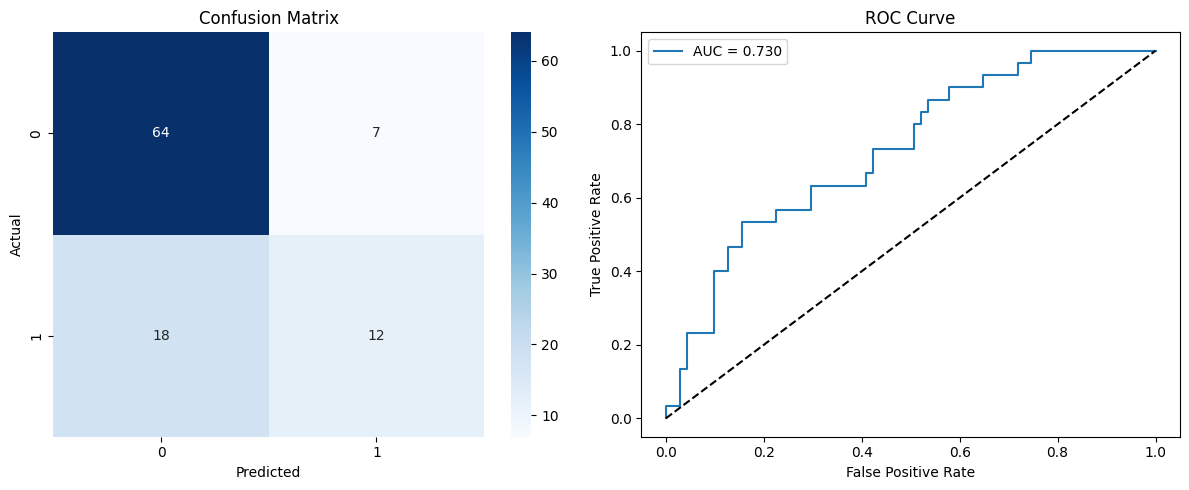

              precision    recall  f1-score   support

       False       0.78      0.90      0.84        71
        True       0.63      0.40      0.49        30

    accuracy                           0.75       101
   macro avg       0.71      0.65      0.66       101
weighted avg       0.74      0.75      0.73       101



In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, classification_report, precision_recall_curve

threshold = 0.5
y_pred_label = (y_pred_proba >= threshold).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_label)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.tight_layout()
plt.show()

# Classification report
print(classification_report(y_test, y_pred_label))

## Model Persistence: Save Trained LightGBM Model

Save the trained LGBMClassifier to Google Drive using joblib, allowing for later reuse without retraining. This is useful for evaluation, deployment, or competition submission.

location: '/content/drive/MyDrive/ADIALab_StructuralBreakChallenge/model_lgbm.joblib'

In [110]:
# Save the model
import joblib
joblib.dump(model, '/content/drive/MyDrive/ADIALab_StructuralBreakChallenge/model_lgbm.joblib')

['/content/drive/MyDrive/ADIALab_StructuralBreakChallenge/model_lgbm.joblib']